In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score, mean_squared_error


import statsmodels.api as sm

# Explore Data

In [2]:
df = pd.read_csv('Data/CarPrice_Assignment.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
df.duplicated().sum()

0

In [4]:
df.isna().sum().sum()

0

In [5]:
df.drop(columns='car_ID', inplace=True)

# Checking for the first two assumptions: linearity and multilinearity between features. (BEFORE MODEL)

## Checking for the Assumption of Linearity

In [6]:
## checking num_cols
num_selector = make_column_selector(dtype_include='number')
num_cols = num_selector(df.drop(columns='price'))
len(num_cols)

14

In [7]:
plot_kws = dict(line_kws = {'color':"red", 'ls':"--"},
                scatter_kws = {'edgecolor':"white", 'lw':1})

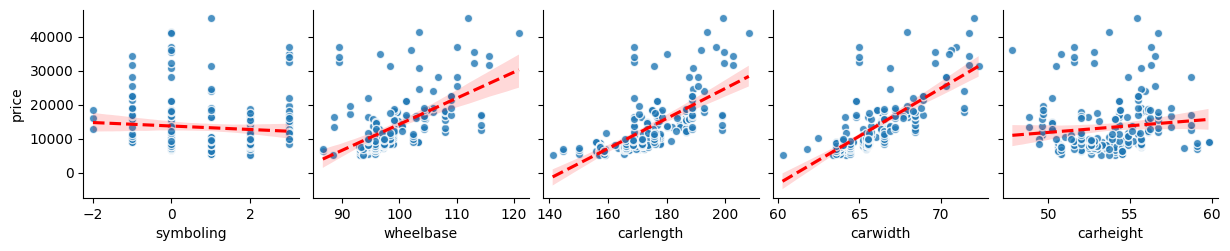

In [8]:
sns.pairplot(df, y_vars='price', x_vars=num_cols[:5], kind='reg',
            plot_kws=plot_kws)

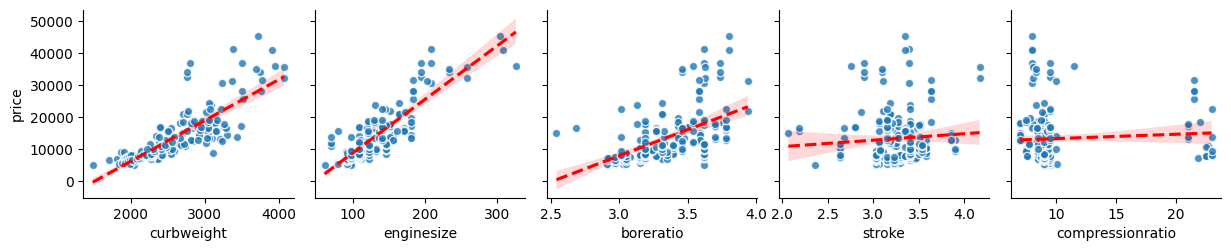

In [9]:
sns.pairplot(df, y_vars='price', x_vars=num_cols[5:10], kind='reg',
            plot_kws=plot_kws)

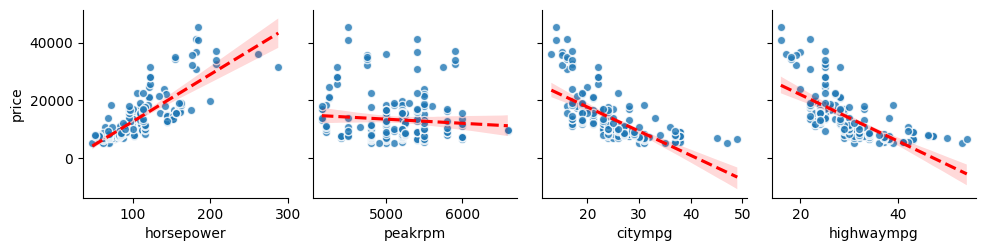

In [10]:
sns.pairplot(df, y_vars='price', x_vars=num_cols[10:], kind='reg',
            plot_kws=plot_kws)

In [11]:
## seems that the stroke and peakrpm don't have a linear relationship with our target, we will drop them. 
df = df.drop(columns=['stroke', 'peakrpm'])

## Checking for the Assumption of Little-to-No Multicollinearity

In [12]:
corr = df.drop(columns='price').corr().abs()
mask = np.triu(np.ones_like(corr))

<AxesSubplot:>

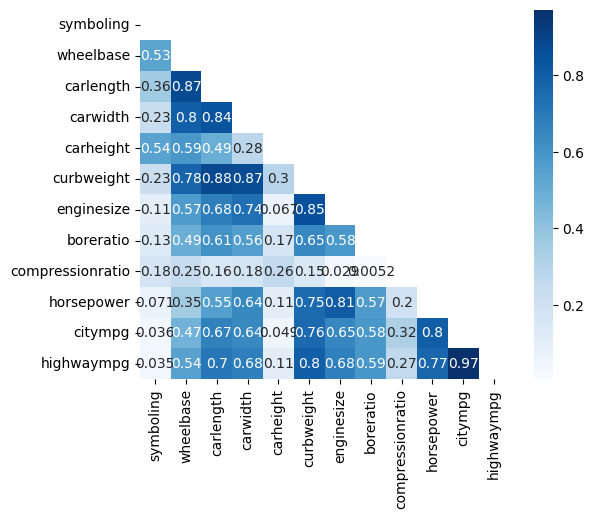

In [13]:
sns.heatmap(corr, square=True, cmap='Blues', annot=True, mask = mask)

we can see that wheelbase and carwidth, wheelbase and carlength, carlength and curbweight, carlength and carwidth, carwidth and curbweight, curbweight and highwaympg, curbweight and enginesize, enginesize and horsepower, horsepower and citympg, citympg and highwaympg have the correlation more than 0.8. we need to think which one of them to drop. 

### identifying correlated features to drop. 

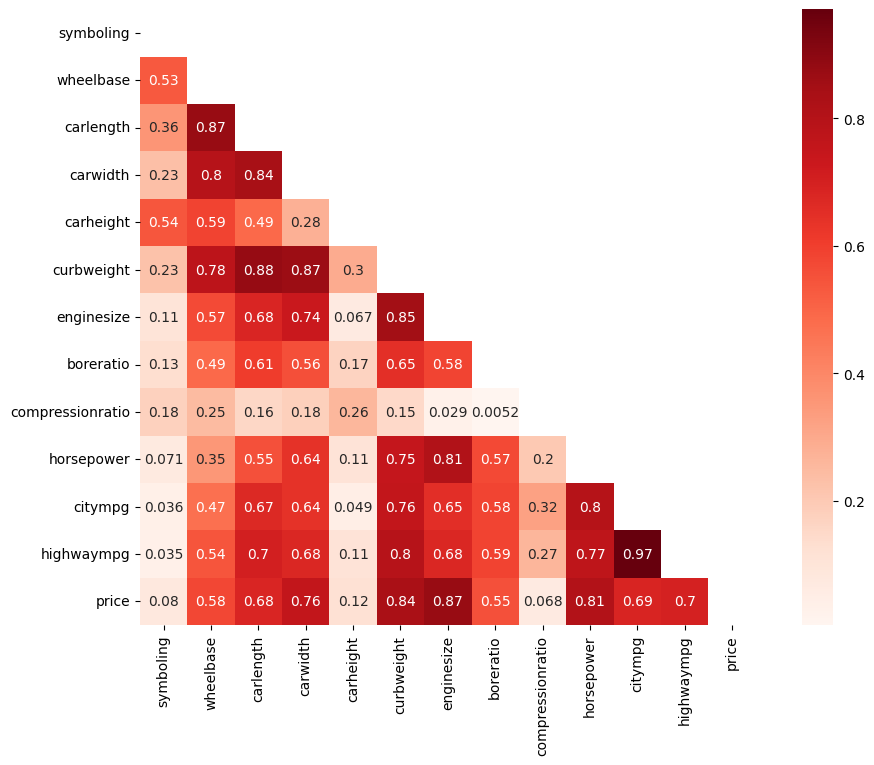

In [14]:
## adding the price back to the correlation heatmap. 
corr = df.corr().abs()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);

we can see that the wheelbase has the least correlation with the price. we can drop wheelbase. after that the carlength and the citympg has the least correlation with price, we can drop carlength and citympg, then we can drop highwaympg 

In [15]:
df = df.drop(columns=['wheelbase', 'carlength', 'citympg', 'highwaympg'])

### double check the multicollinearity via correlation

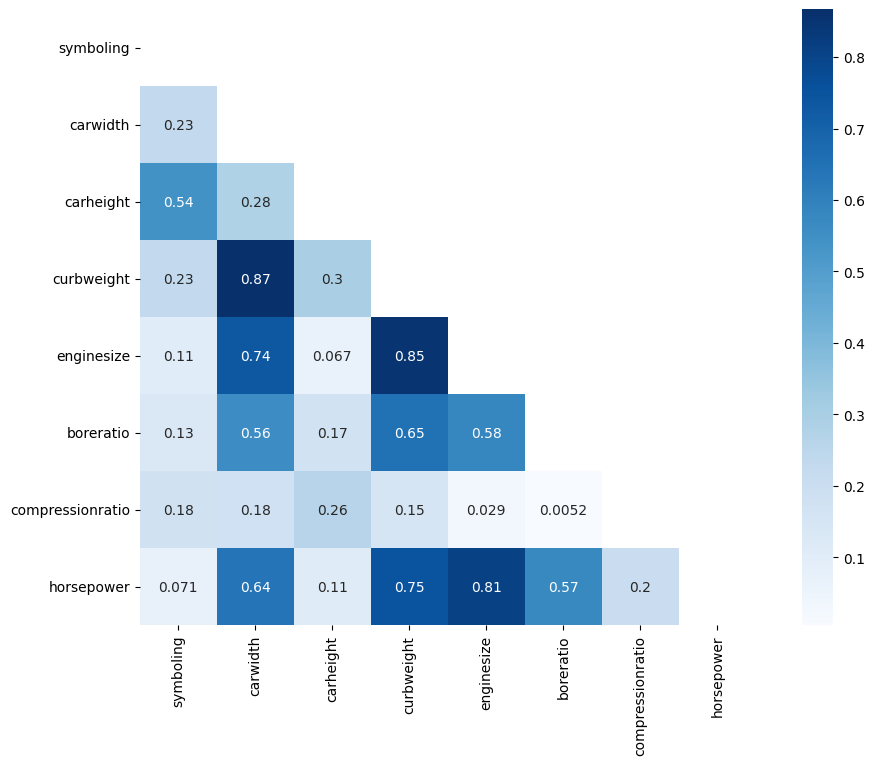

In [16]:
corr = df.drop(columns='price').corr().abs()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr,square=True, cmap='Blues', annot=True, mask=mask);

we can see that we still have carwidth and curbweight, curbweight and enginesize have strong correlation.
we need to drop curbweight to remove both the strong correlations

In [17]:
df = df.drop(columns= ['horsepower', 'curbweight'])

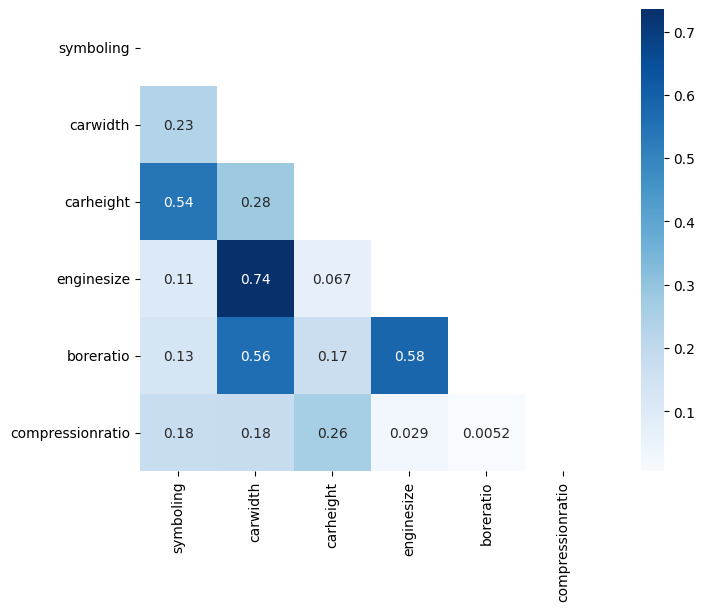

In [18]:
## checking the multilinearity via correlation again
corr = df.drop(columns='price').corr().abs()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(corr,square=True, cmap='Blues', annot=True, mask=mask);

Much better!!

# Running the Model

In [19]:
## Make x and y variables
y = df['price'].copy()
X = df.drop(columns=['price','CarName']).copy()
X_train,X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,carwidth,carheight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,compressionratio
17,0,gas,std,four,sedan,rwd,front,70.9,56.3,ohc,six,209,mpfi,3.62,8.0
39,0,gas,std,four,sedan,fwd,front,65.2,54.1,ohc,four,110,1bbl,3.15,9.0
40,0,gas,std,four,sedan,fwd,front,62.5,54.1,ohc,four,110,1bbl,3.15,9.0
47,0,gas,std,four,sedan,rwd,front,69.6,52.8,dohc,six,258,mpfi,3.63,8.1
123,-1,gas,std,four,wagon,fwd,front,64.6,59.8,ohc,four,122,2bbl,3.35,8.5


In [20]:
## make cat selector and num_selector using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)

In [21]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False)
                        )
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## get the preprocessor
preprocessor = make_column_transformer( (num_pipe, num_cols),
                                       (cat_pipe,cat_cols),
                                       remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['symboling', 'carwidth', 'carheight',
                                  'enginesize', 'boreratio',
                                  'compressionratio']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['fueltype', 'aspiration', 'doornumber',
                                  'carbody', 'drivewheel', 'enginelocation',
                                  'enginetype', 'cylindernumber',
                                  'fuelsystem'])])

In [22]:
## fit the proprocessor to learn feature names
preprocessor.fit(X_train)

## create a list of an empty final feature names.
final_features = []

## add the num_cols first to the empty final_features list
final_features.extend(num_cols)

## get cat_features names used to add to the final_features list
cat_features = preprocessor.named_transformers_['pipeline-2'][1].get_feature_names_out(cat_cols)

## add cat_features to the final_features list
final_features.extend(cat_features)

## Transform x_vas and remake as dataframes.
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=final_features,
                          index=X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         columns=final_features,
                         index=X_test.index)

## print the head()of the x_test_df
display(X_test_df.head(2))
display(X_train_df.head(2))

,symboling,carwidth,carheight,enginesize,boreratio,compressionratio,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
48,0.0,69.6,52.8,258.0,3.63,8.1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
196,-2.0,67.2,56.2,141.0,3.78,9.5,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,symboling,carwidth,carheight,enginesize,boreratio,compressionratio,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
17,0.0,70.9,56.3,209.0,3.62,8.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
39,0.0,65.2,54.1,110.0,3.15,9.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
## Adding constants for statsmodels
X_train_df = sm.add_constant(X_train_df, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_df, prepend=False)
display(X_train_df.head(2))
display(X_test_df.head(2))

,symboling,carwidth,carheight,enginesize,boreratio,compressionratio,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,const
17,0.0,70.9,56.3,209.0,3.62,8.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
39,0.0,65.2,54.1,110.0,3.15,9.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,symboling,carwidth,carheight,enginesize,boreratio,compressionratio,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,...,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,const
48,0.0,69.6,52.8,258.0,3.63,8.1,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
196,-2.0,67.2,56.2,141.0,3.78,9.5,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Fitting the Regression Model

In [24]:
## make & fit a statsmodels OLS
model = sm.OLS(y_train,X_train_df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     36.10
Date:                Wed, 12 Oct 2022   Prob (F-statistic):           1.38e-47
Time:                        18:29:04   Log-Likelihood:                -1405.0
No. Observations:                 153   AIC:                             2876.
Df Residuals:                     120   BIC:                             2976.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
symboling               266.57

# Checking the last two assumptions: the residuals(AFTER MODEL)

In [25]:
## create a function for both QQ plot and residual plot. 
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

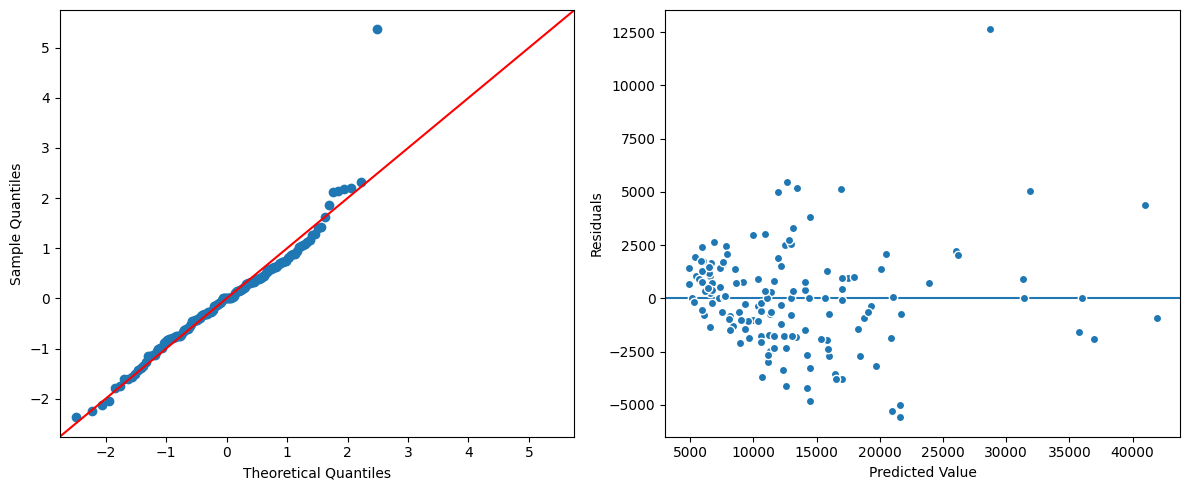

In [26]:
evaluate_ols(result,X_train_df, y_train)

## Diagnosing the Model

## Removing Outliers

In [27]:
## using the z-score, so 
scaler = StandardScaler()
z_price = scaler.fit_transform(y_train.values.reshape(-1,1)) # we can get the 2D arrays

## convert the 2D arrays into a pd.series, we need to flattern the array back to a 1D array with flattern()
z_price = pd.Series(z_price.flatten(),index=y_train.index )

## saving the true/false result as our outlier index. which the true indicates an outlier.
idx_outliers= z_price>3


## how many outliers did we find? 
## idx_outliers.sum()

## saving a cleaned version of y_train and X_train with outliers removed
y_train_cln = y_train[~idx_outliers]
X_train_cln = X_train_df[~idx_outliers]

In [28]:
## we want to know what values of price were removed from our analysis?
print("Our model includes cars priced:")
print(f"- Greater than ${y_train_cln.min():,.2f}")
print(f"- Less than ${y_train_cln.max():,.2f}")

Our model includes cars priced:
- Greater than $5,118.00
- Less than $36,000.00


In [29]:
## Use the same criterion to remove outliers from the test data

# Getting scaled y_test
z_price_test = scaler.transform(y_test.values.reshape(-1,1))
z_price_test = pd.Series(z_price_test.flatten(),index=y_test.index )
# saving the true/false result as our outlier index
idx_outliers_test= z_price_test>3


## make clean version of X_test and y_test
X_test_cln = X_test_df[~idx_outliers_test] 
y_test_cln = y_test[~idx_outliers_test]

## A New Model after Outliers Removed

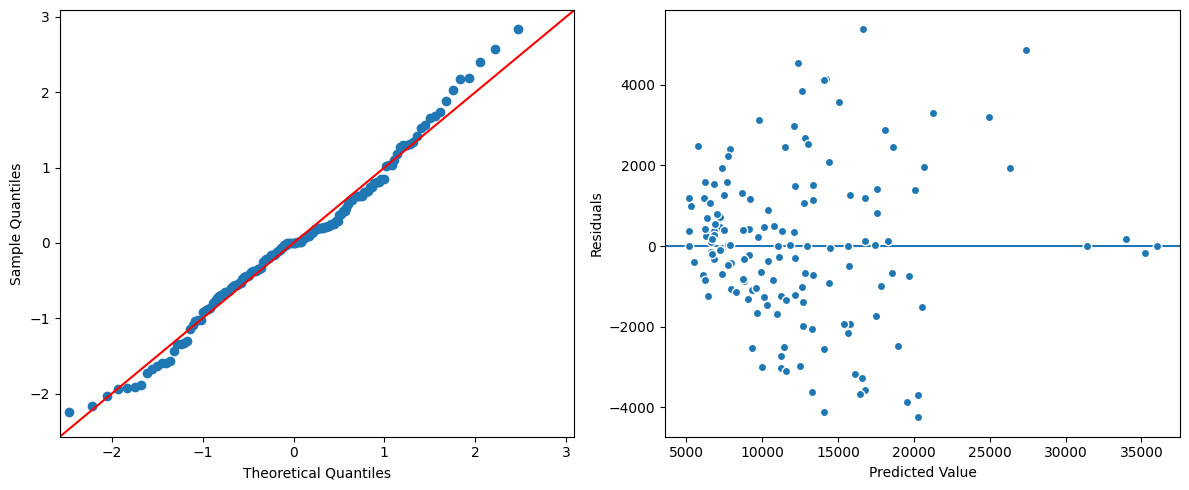

In [30]:
## make & fit a statmsodels OLS
model = sm.OLS(y_train_cln,X_train_cln)
result = model.fit()
evaluate_ols(result,X_train_cln,y_train_cln)

## Final Diagnostic Step: Remove Columns with Insignificant P-Values

In [31]:
## save p-values
p_vals = result.pvalues
## filter for p_values that are >.05
p_vals[p_vals>.05]

symboling                0.097046
boreratio                0.890817
compressionratio         0.981086
fueltype_diesel          0.104280
carbody_convertible      0.831006
enginetype_dohc          0.330675
enginetype_dohcv         0.474729
enginetype_ohc           0.618202
enginetype_ohcf          0.292729
enginetype_rotor         0.304428
cylindernumber_eight     0.262767
cylindernumber_three     0.934437
cylindernumber_twelve    0.557499
cylindernumber_two       0.304428
fuelsystem_1bbl          0.756636
fuelsystem_2bbl          0.437797
fuelsystem_4bbl          0.176881
fuelsystem_idi           0.104280
fuelsystem_mfi           0.317091
fuelsystem_mpfi          0.801143
fuelsystem_spdi          0.121890
fuelsystem_spfi          0.556957
dtype: float64

As we can see, we will drop some of the columns, but with enginetype columns, cylindernumber, fuelsystem, we need to find out how many those columns total. 

In [32]:
enginetype_cols = [col for col in X_train_df.columns if col.startswith('enginetype')]
print(len(enginetype_cols))

7


In [33]:
cylindernumber_cols = [col for col in X_train_df.columns if col.startswith('cylindernumber')]
print(len(cylindernumber_cols))

7


In [34]:
fuelsystem_cols = [col for col in X_train_df.columns if col.startswith('fuelsystem')]
print(len(fuelsystem_cols))

8


we will remove all of columns with the pvalues >0.05

In [42]:
X_train_df = X_train_df.loc[:, ~X_train_df.columns.str.startswith('enginetype')]
X_train_df = X_train_df.loc[:, ~X_train_df.columns.str.startswith('cylindernumber')]
X_train_df = X_train_df.loc[:, ~X_train_df.columns.str.startswith('fuelsystem')]
X_train_df = X_train_df.drop(columns = ['symboling', 'boreratio', 'compressionratio', 'fueltype_diesel', 'carbody_convertible'])

In [43]:
X_train_df.head()

,carwidth,carheight,enginesize,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,const
17,70.9,56.3,209.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
39,65.2,54.1,110.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
40,62.5,54.1,110.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
47,69.6,52.8,258.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
123,64.6,59.8,122.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


## Evaluating the Model on the Testing Data

R-Squared for Test Data: 0.91


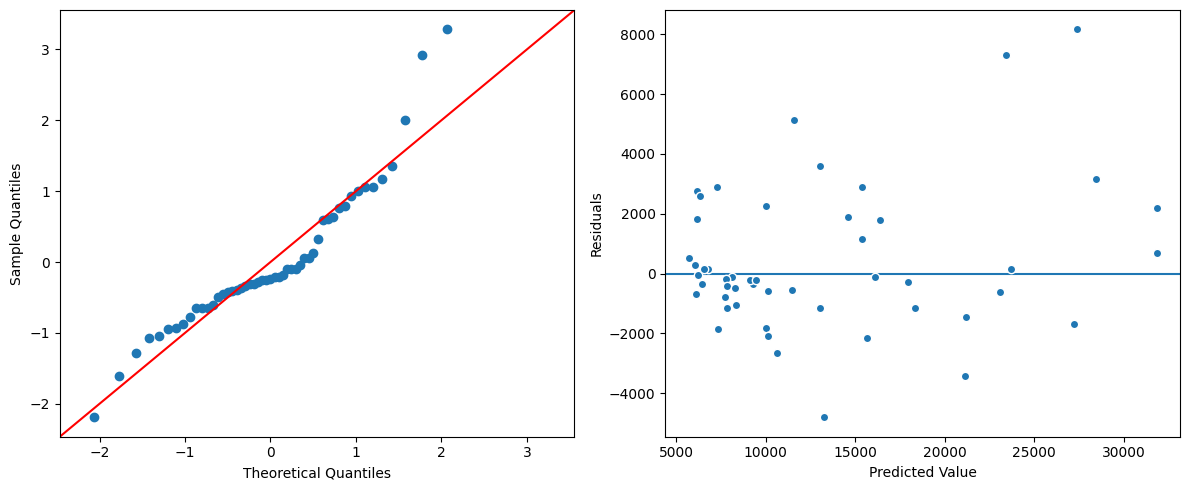

In [44]:
## evaluate test
r2_test = r2_score(y_test_cln, result.predict(X_test_cln))
print(f"R-Squared for Test Data: {r2_test:.2f}")
evaluate_ols(result,X_test_cln, y_test_cln)